In [1]:
# experiment.py
import torch
import torch.nn as nn
import numpy as np
import random

# Set ALL the seeds for reproducibility
def set_seed(seed=42):
    """Set all random seeds for complete reproducibility."""
    # Python's built-in random module
    random.seed(seed)
    
    # NumPy random 
    np.random.seed(seed)
    
    # PyTorch CPU random
    torch.manual_seed(seed)
    
    # PyTorch CUDA random (if available)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU
        
    # Make CuDNN deterministic for reproducibility (may impact performance)
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

if __name__ == "__main__":
    set_seed(42)
    print("Seeds set. Ready for deterministic exploration.")

Seeds set. Ready for deterministic exploration.


In [2]:
if __name__ == "__main__":
    set_seed(42)
    a = torch.randn(3)
    print(a)
    set_seed(42)
    b = torch.randn(3)
    print(b)
    print(f"Identical? {torch.equal(a, b)}")  # Should be True

tensor([0.3367, 0.1288, 0.2345])
tensor([0.3367, 0.1288, 0.2345])
Identical? True


In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=16, n_heads=2):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads  # 16/2 = 8 dims per head
        
        # Create Q, K, V projections
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_O = nn.Linear(d_model, d_model)
        
    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        
        # Project to Q, K, V
        Q = self.W_Q(x)  # [batch, seq, d_model]
        K = self.W_K(x)  # You implement
        V = self.W_V(x) # You implement
        
        # Reshape for multi-head attention
        # We need [batch, n_heads, seq, d_head]
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2) # You reshape K the same way
        V = V.view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)  # You reshape V the same way
        
            # Compute attention scores
        scores = Q @ K.transpose(2,3) / (self.d_head ** 0.5)        
        # Apply attention to values
        attn_weights = torch.softmax(scores, dim=-1)  # How do you turn scores into probabilities?
        self.last_attn_weights = attn_weights  # Save for analysis!
        attn_output = attn_weights @ V  # How do you apply weights to V?
        attn_output = attn_output.transpose(1,2).reshape(batch_size, seq_len, d_model)

        attn_output = self.W_O(attn_output)
        return attn_output, attn_weights
        


In [4]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model=16, n_heads=2, d_ff=64):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Feedforward network
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        
    def forward(self, x):
        # Attention block with residual
        attn_out, attn_weights = self.attn(x)
        x = x + attn_out  # How do you combine x and attn_out (residual)?
        x = self.norm1(x)  # Apply layer norm
        
        # Feedforward block with residual  
        ff_out = self.ff(x)
        x = x + ff_out  # Residual connection
        x = self.norm2(x)  # Layer norm
        
        return x, attn_weights

In [5]:
class TinyTransformer(nn.Module):
    def __init__(self, d_model=16, n_heads=2, n_layers=2, vocab_size=10, seq_len=8):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(seq_len, d_model)
        
        self.layers = nn.ModuleList([
            TransformerLayer(d_model, n_heads, d_ff=4*d_model) 
            for _ in range(n_layers)
        ])
        
        self.output = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        batch_size, seq_len = x.shape
        
        # Get embeddings
        tok_emb = self.token_embed(x)
        # Create positions on the same device as x
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        pos_emb = self.pos_embed(positions)
        
        # Combine
        embeddings = tok_emb + pos_emb
        
        # Pass through layers, collecting attention weights
        hidden = embeddings
        attention_maps = []
        for layer in self.layers:
            hidden, attn_weights = layer(hidden)
            attention_maps.append(attn_weights)
            
        logits = self.output(hidden)
        return logits, attention_maps

In [6]:
set_seed(42)
model = TinyTransformer()
test_input = torch.randint(0, 10, (2, 8))
logits, attn_maps = model(test_input)
print(f"Logits: {logits.shape}")
print(f"Attention maps: {len(attn_maps)} layers, each {attn_maps[0].shape}")

Logits: torch.Size([2, 8, 10])
Attention maps: 2 layers, each torch.Size([2, 2, 8, 8])


In [7]:
def create_probe_sequences():
    """Create sequences to test what neurons respond to"""
    probes = {}
    
    # Position probes - same token in different positions
    probes['position'] = torch.tensor([[5,5,5,5,5,5,5,5]])  # All same token
    
    # Token identity probes - different tokens  
    probes['token'] = torch.tensor([[0,1,2,3,4,5,6,7]])  # Different tokens
    
    # Specific position-token combinations
    # Token 7 at position 3 only
    probes['position_token'] = torch.tensor([[0,0,0,7,0,0,0,0]])
    
    return probes

# ============================================================================
# MECHANISTIC INTERPRETABILITY TOOLKIT
# Day 1: Core observation and intervention tools
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Tuple
import torch.nn.functional as F

In [8]:
# 1. ACTIVATION CACHE - Spy on the forward pass
class ActivationCache:
    """
    Non-invasive activation capture using PyTorch hooks.
    This lets us observe what happens inside the model during forward passes.
    
    Key concepts:
    - Hooks don't modify the computation, just observe
    - We detach tensors to avoid memory issues
    - Can capture any layer's input/output
    """
    def __init__(self):
        self.activations = {}
        self.hooks = []
        
    def create_hook(self, name):
        """Create a hook function that stores activations."""
        def hook(module, input, output):
            if isinstance(output, tuple):
                self.activations[name] = output[0].clone().detach()
            else:
                self.activations[name] = output.clone().detach()
        return hook
    
    def register_hooks(self, model, include_mlp_neurons=False):
        """Register hooks on specific layers we want to observe.
        
        Args:
            model: The transformer model
            include_mlp_neurons: If True, also hook into MLP neurons (post-ReLU)
        """
        # Hook into attention layers
        for i, layer in enumerate(model.layers):
            # Attention outputs
            hook = layer.attn.register_forward_hook(self.create_hook(f'attn_{i}'))
            self.hooks.append(hook)
            
            # Feedforward outputs (residual stream)
            hook = layer.ff.register_forward_hook(self.create_hook(f'ff_{i}'))
            self.hooks.append(hook)
            
            # NEW: Hook into MLP neurons (post-ReLU activations)
            if include_mlp_neurons:
                # The FF block structure: Linear -> ReLU -> Linear
                # layer.ff[1] is the ReLU layer
                hook = layer.ff[1].register_forward_hook(self.create_hook(f'mlp_neurons_{i}'))
                self.hooks.append(hook)
            
        # Hook into embeddings
        hook = model.token_embed.register_forward_hook(self.create_hook('embed'))
        self.hooks.append(hook)
        
        # Hook into final output
        hook = model.output.register_forward_hook(self.create_hook('logits'))
        self.hooks.append(hook)
        
        return self
    
    def clear(self):
        """Clear stored activations."""
        self.activations = {}
    
    def remove_hooks(self):
        """Remove all hooks from the model."""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        
    def __getitem__(self, key):
        """Easy access to activations."""
        return self.activations[key]

In [9]:
# 2. LOGIT LENS - Decode hidden states into vocabulary
def logit_lens(model, hidden_states):
    """
    The logit lens lets us interpret any hidden state as a distribution over tokens.
    
    Key insight: The residual stream at ANY point contains interpretable information!
    We can decode it by applying the final output projection.
    
    Args:
        model: The transformer model
        hidden_states: Activations from any layer [batch, seq, d_model]
    
    Returns:
        logits: Distribution over vocabulary [batch, seq, vocab_size]
    """
    # Since TinyTransformer doesn't have a final LN before output,
    # we directly project through the output layer
    return model.output(hidden_states)

def visualize_logit_lens(model, input_ids, cache, top_k=3):
    """
    Visualize what tokens the model is 'thinking about' at each layer.
    
    Shows top-k predicted tokens at each position and layer.
    """
    import matplotlib.pyplot as plt
    
    # Vocabulary for visualization (using indices as tokens since vocab_size=10)
    vocab = [str(i) for i in range(10)]
    
    # Layers to analyze
    layers_to_check = ['embed', 'attn_0', 'ff_0', 'attn_1', 'ff_1', 'logits']
    
    batch_size, seq_len = input_ids.shape
    
    # Create visualization
    fig, axes = plt.subplots(len(layers_to_check), 1, figsize=(12, 2*len(layers_to_check)))
    if len(layers_to_check) == 1:
        axes = [axes]
    
    for layer_idx, layer_name in enumerate(layers_to_check):
        if layer_name in cache.activations:
            # Get activations for this layer
            activations = cache.activations[layer_name]
            
            if layer_name == 'logits':
                # Already logits, no need to apply logit lens
                logits = activations
            else:
                # Apply logit lens to get predictions
                logits = logit_lens(model, activations)
            
            # Get top-k predictions for each position
            probs = torch.softmax(logits[0], dim=-1)  # First batch item
            top_probs, top_indices = torch.topk(probs, k=min(top_k, 10), dim=-1)
            
            # Create text representation
            ax = axes[layer_idx]
            ax.set_title(f"Layer: {layer_name}")
            ax.set_xlim(0, seq_len)
            ax.set_ylim(0, top_k)
            ax.set_xlabel("Position")
            ax.set_ylabel("Top Predictions")
            
            # Plot top predictions at each position
            for pos in range(seq_len):
                for k in range(min(top_k, 10)):
                    token_id = top_indices[pos, k].item()
                    prob = top_probs[pos, k].item()
                    color_intensity = prob  # Use probability for color intensity
                    
                    # Display token with probability
                    ax.text(pos + 0.5, top_k - k - 0.5, 
                           f"{vocab[token_id]}\n{prob:.2f}",
                           ha='center', va='center',
                           fontsize=8,
                           bbox=dict(boxstyle="round,pad=0.3", 
                                   facecolor=plt.cm.Blues(color_intensity),
                                   alpha=0.7))
            
            ax.set_xticks(range(seq_len + 1))
            ax.set_yticks([])
            ax.grid(True, axis='x', alpha=0.3)
    
    plt.suptitle("Logit Lens: Model's Token Predictions Across Layers", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return fig

In [10]:
# Test the logit lens - see what the model is "thinking"
set_seed(42)
model = TinyTransformer()
cache = ActivationCache()
cache.register_hooks(model)

# Create a simple test sequence
test_input = torch.tensor([[1, 2, 3, 4, 1, 2, 3, 4]])  # Repeating pattern
print(f"Input sequence: {test_input[0].tolist()}")
print(f"Input shape: {test_input.size()}")
# Run forward pass to collect activations
logits, attn_maps = model(test_input)

# Now use logit lens at different layers
print("\n🔍 Logit Lens Analysis - What is the model thinking?")
print("-" * 50)

# Check embeddings
embed_logits = logit_lens(model, cache['embed'])
print(f"After embeddings, shape: {embed_logits.shape}")
top_tokens_embed = embed_logits[0, -1].argmax()  # Last position prediction
print(f"  Top predicted token at last position: {top_tokens_embed.item()}")

# Check after first attention layer
attn0_logits = logit_lens(model, cache['attn_0'])
top_tokens_attn0 = attn0_logits[0, -1].argmax()
print(f"\nAfter attention layer 0:")
print(f"  Top predicted token at last position: {top_tokens_attn0.item()}")

# Check after first feedforward
ff0_logits = logit_lens(model, cache['ff_0'])
top_tokens_ff0 = ff0_logits[0, -1].argmax()
print(f"\nAfter feedforward layer 0:")
print(f"  Top predicted token at last position: {top_tokens_ff0.item()}")

# Final output
final_top = logits[0, -1].argmax()
print(f"\nFinal model output:")
print(f"  Top predicted token at last position: {final_top.item()}")

print("\n💡 Notice: Even a random model has preferences at each layer!")
print("This is evidence of pre-existing structure in random networks.")

# Clean up
cache.remove_hooks()

Input sequence: [1, 2, 3, 4, 1, 2, 3, 4]
Input shape: torch.Size([1, 8])

🔍 Logit Lens Analysis - What is the model thinking?
--------------------------------------------------
After embeddings, shape: torch.Size([1, 8, 10])
  Top predicted token at last position: 1

After attention layer 0:
  Top predicted token at last position: 6

After feedforward layer 0:
  Top predicted token at last position: 6

Final model output:
  Top predicted token at last position: 8

💡 Notice: Even a random model has preferences at each layer!
This is evidence of pre-existing structure in random networks.


In [11]:
# 3. ATTENTION VISUALIZATION - See what the model is looking at
def visualize_attention_patterns(attention_weights, input_ids=None, layer_idx=0, head_idx=None):
    """
    Visualize attention patterns to understand information flow.
    
    Common patterns to look for:
    - Diagonal: attending to self
    - Previous token: attending to the token before
    - Induction: copying patterns from earlier in sequence
    - Global: attending to specific positions (e.g., first token)
    
    Args:
        attention_weights: [batch, n_heads, seq_len, seq_len] or [batch, seq_len, seq_len]
        input_ids: Optional token ids for labels
        layer_idx: Which layer we're visualizing
        head_idx: Specific head to visualize (None = average all heads)
    """
    # Handle different shapes
    if len(attention_weights.shape) == 4:
        batch_size, n_heads, seq_len, _ = attention_weights.shape
        if head_idx is not None:
            attn = attention_weights[0, head_idx].detach().cpu().numpy()
            title = f"Layer {layer_idx}, Head {head_idx}"
        else:
            # Average over heads
            attn = attention_weights[0].mean(dim=0).detach().cpu().numpy()
            title = f"Layer {layer_idx}, Averaged Heads"
    else:
        attn = attention_weights[0].detach().cpu().numpy()
        title = f"Layer {layer_idx}"
    
    # Create visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, cmap='Blues', cbar=True, square=True)
    plt.title(title)
    plt.xlabel("Position (attending to)")
    plt.ylabel("Position (attending from)")
    
    # Add token labels if provided
    if input_ids is not None:
        tokens = input_ids[0].cpu().numpy()
        plt.xticks(range(len(tokens)), tokens, rotation=45)
        plt.yticks(range(len(tokens)), tokens)
    
    plt.tight_layout()
    plt.show()

def identify_attention_patterns(attention_weights, threshold=0.1):
    """
    Automatically identify common attention patterns.
    """
    # Handle both 3D and 4D tensors
    if len(attention_weights.shape) == 4:
        # [batch, n_heads, seq, seq]
        batch, n_heads, seq_len, _ = attention_weights.shape
        attn = attention_weights[0]  # Take first batch item
    else:
        # [batch, seq, seq] - extract seq_len here for 3D case
        batch, seq_len, _ = attention_weights.shape
        attn = attention_weights[0].unsqueeze(0)  # Add head dimension
        n_heads = 1

    patterns = {
        'diagonal': [],
        'previous': [],
        'first': [],
        'uniform': []
    }

    for head_idx in range(attn.shape[0]):
        head_attn = attn[head_idx]  # [seq, seq]

        # Diagonal (self-attention)
        diagonal_avg = head_attn.diagonal().mean().item()
        patterns['diagonal'].append(diagonal_avg)

        # Previous token (offset=-1 diagonal)
        if seq_len > 1:
            prev_diag = head_attn.diagonal(offset=-1)
            previous_avg = prev_diag.mean().item() if len(prev_diag) > 0 else 0
        else:
            previous_avg = 0
        patterns['previous'].append(previous_avg)

        # First token attention (column 0)
        first_avg = head_attn[:, 0].mean().item()
        patterns['first'].append(first_avg)

        # Uniformity (lower std = more uniform)
        # Perfect uniform would be 1/seq_len everywhere, std would be 0
        uniformity = 1 - head_attn.std().item()  # Simple std across all values
        patterns['uniform'].append(uniformity)

    return patterns

In [12]:
# Test attention pattern identification
set_seed(42)
model = TinyTransformer()

# Create different test sequences to see different patterns
test_sequences = {
    'repeating': torch.tensor([[1, 2, 3, 4, 1, 2, 3, 4]]),
    'ascending': torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7]]),
    'constant': torch.tensor([[5, 5, 5, 5, 5, 5, 5, 5]])
}

print("🔍 Attention Pattern Analysis")
print("=" * 50)

for seq_name, seq in test_sequences.items():
    print(f"\n{seq_name.upper()} sequence: {seq[0].tolist()}")
    print("-" * 40)
    
    # Get attention patterns
    logits, attn_maps = model(seq)
    
    # Analyze each layer
    for layer_idx, attn in enumerate(attn_maps):
        patterns = identify_attention_patterns(attn)
        
        print(f"\nLayer {layer_idx}:")
        for head_idx in range(len(patterns['diagonal'])):
            print(f"  Head {head_idx}:")
            print(f"    Self-attention: {patterns['diagonal'][head_idx]:.3f}")
            print(f"    Previous token: {patterns['previous'][head_idx]:.3f}")
            print(f"    First token:    {patterns['first'][head_idx]:.3f}")
            print(f"    Uniformity:     {patterns['uniform'][head_idx]:.3f}")
            
            # Identify dominant pattern
            scores = {
                'self': patterns['diagonal'][head_idx],
                'previous': patterns['previous'][head_idx],
                'first': patterns['first'][head_idx]
            }
            dominant = max(scores, key=scores.get)
            print(f"    → Dominant: {dominant} attention")

print("\n💡 Even random models show structured attention patterns!")

🔍 Attention Pattern Analysis

REPEATING sequence: [1, 2, 3, 4, 1, 2, 3, 4]
----------------------------------------

Layer 0:
  Head 0:
    Self-attention: 0.138
    Previous token: 0.105
    First token:    0.141
    Uniformity:     0.941
    → Dominant: first attention
  Head 1:
    Self-attention: 0.078
    Previous token: 0.117
    First token:    0.087
    Uniformity:     0.930
    → Dominant: previous attention

Layer 1:
  Head 0:
    Self-attention: 0.119
    Previous token: 0.143
    First token:    0.129
    Uniformity:     0.937
    → Dominant: previous attention
  Head 1:
    Self-attention: 0.117
    Previous token: 0.117
    First token:    0.109
    Uniformity:     0.968
    → Dominant: self attention

ASCENDING sequence: [0, 1, 2, 3, 4, 5, 6, 7]
----------------------------------------

Layer 0:
  Head 0:
    Self-attention: 0.121
    Previous token: 0.121
    First token:    0.127
    Uniformity:     0.913
    → Dominant: first attention
  Head 1:
    Self-attention: 0.

In [13]:
# TEST YOUR IMPLEMENTATION - Morning checkpoint
def test_hooks_and_cache():
    """Test that your hook implementation works correctly."""
    set_seed(42)
    model = TinyTransformer()
    cache = ActivationCache()
    
    # Register hooks
    cache.register_hooks(model)
    
    # Run forward pass
    test_input = torch.randint(0, 10, (1, 8))
    logits, attn_maps = model(test_input)
    
    # Check that activations were captured
    print("Captured activations:")
    for key in cache.activations:
        if isinstance(cache.activations[key], tuple):
            print(f"  {key}: {cache.activations[key][0].shape}")
        else:
            print(f"  {key}: {cache.activations[key].shape}")
    
    # Clean up
    cache.remove_hooks()
    return cache

# Run this after implementing the TODOs above
cache = test_hooks_and_cache()

Captured activations:
  embed: torch.Size([1, 8, 16])
  attn_0: torch.Size([1, 8, 16])
  ff_0: torch.Size([1, 8, 16])
  attn_1: torch.Size([1, 8, 16])
  ff_1: torch.Size([1, 8, 16])
  logits: torch.Size([1, 8, 10])


In [14]:
# Let's test your hook implementation!
set_seed(42)
model = TinyTransformer()
cache = ActivationCache()

# Register hooks
cache.register_hooks(model)

# Run forward pass
test_input = torch.randint(0, 10, (1, 8))
print(f"Input sequence: {test_input[0].tolist()}")

logits, attn_maps = model(test_input)

# Check what we captured
print("\n✅ Successfully captured activations:")
for key in sorted(cache.activations.keys()):
    act = cache.activations[key]
    if isinstance(act, tuple):
        shape = act[0].shape if hasattr(act[0], 'shape') else type(act[0])
    else:
        shape = act.shape if hasattr(act, 'shape') else type(act)
    print(f"  {key}: {shape}")

# Clean up
cache.remove_hooks()

print("\n🎉 Hooks working perfectly! You can now observe any layer's activations.")

Input sequence: [7, 7, 0, 5, 5, 3, 0, 3]

✅ Successfully captured activations:
  attn_0: torch.Size([1, 8, 16])
  attn_1: torch.Size([1, 8, 16])
  embed: torch.Size([1, 8, 16])
  ff_0: torch.Size([1, 8, 16])
  ff_1: torch.Size([1, 8, 16])
  logits: torch.Size([1, 8, 10])

🎉 Hooks working perfectly! You can now observe any layer's activations.


In [15]:
# ============================================================================
# PART 2: INTERVENTION TOOLS - Understanding causality
# ============================================================================

# 4. ACTIVATION PATCHING - Test causal importance
def activation_patching(model, clean_input, corrupted_input, layer_name, cache_clean, cache_corrupted, metric_fn):
    """
    Activation patching reveals which components are causally important.
    
    Method:
    1. Run model on corrupted input (e.g., with critical info removed)
    2. Run model on clean input
    3. Replace specific activation from corrupted run with clean activation
    4. If performance recovers, that activation was crucial!
    
    Args:
        model: The transformer model
        clean_input: Input with correct information
        corrupted_input: Input with information removed/corrupted
        layer_name: Which activation to patch (e.g., 'attn_0', 'ff_1')
        cache_clean: ActivationCache from clean run
        cache_corrupted: ActivationCache from corrupted run (for consistency, not used)
        metric_fn: Function to measure performance (higher = better)
    
    Returns:
        patched_metric: Performance after patching
        baseline_metric: Performance without patching (corrupted)
        clean_metric: Performance on clean input (upper bound)
    """
    # Get clean activation for patching
    clean_activation = cache_clean[layer_name]
    
    # Create a patching hook that will replace activations during forward pass
    def patching_hook(module, input, output):
        if isinstance(output, tuple):
            # For attention layers that return (output, attention_weights)
            output = (clean_activation, output[1])
        else:
            # For other layers that return just the activation
            output = clean_activation
        return output
    
    # Register the patching hook on the appropriate layer
    target_module = None
    if 'attn' in layer_name:
        layer_idx = int(layer_name.split('_')[1])
        target_module = model.layers[layer_idx].attn
    elif 'ff' in layer_name:
        layer_idx = int(layer_name.split('_')[1])
        target_module = model.layers[layer_idx].ff
    elif layer_name == 'embed':
        target_module = model.token_embed
    
    # Register hook and run patched forward pass
    hook_handle = target_module.register_forward_hook(patching_hook)
    
    with torch.no_grad():
        # Run on corrupted input with patching
        patched_output, _ = model(corrupted_input)
        patched_metric = metric_fn(patched_output, corrupted_input)
        
        # Clean up hook
        hook_handle.remove()
        
        # Get baseline metrics
        corrupted_output, _ = model(corrupted_input)
        baseline_metric = metric_fn(corrupted_output, corrupted_input)
        
        clean_output, _ = model(clean_input)
        clean_metric = metric_fn(clean_output, clean_input)
    
    return patched_metric, baseline_metric, clean_metric

# 5. ABLATION STUDIES - Remove components to test importance
def ablate_neurons(model, layer_name, neuron_indices, replacement='zero', mean_cache=None):
    """
    Ablate (remove) specific neurons to test their importance.
    
    Replacement strategies:
    - 'zero': Set activations to 0
    - 'mean': Replace with mean activation (requires mean_cache)
    - 'random': Replace with random noise
    
    Args:
        model: The transformer model
        layer_name: Which layer to ablate (e.g., 'ff_0')
        neuron_indices: List of neuron indices to ablate
        replacement: How to replace ablated neurons
        mean_cache: Dict with mean activations for each layer (required for 'mean' strategy)
    """
    def ablation_hook(module, input, output):
        # Handle tuple case (attention layers)
        if isinstance(output, tuple):
            # Clone the first element (the actual activation)
            modified = output[0].clone()
            # Apply ablation to specific neurons
            if replacement == 'zero':
                modified[..., neuron_indices] = 0
            elif replacement == 'mean':
                if mean_cache and layer_name in mean_cache:
                    # Replace with pre-computed mean values for those specific neurons
                    mean_values = mean_cache[layer_name][neuron_indices]
                    # Broadcast mean values to match modified shape [batch, seq, hidden]
                    modified[..., neuron_indices] = mean_values
                else:
                    # Fallback: use mean across current batch and sequence
                    mean_val = modified.mean(dim=(0, 1))  # [hidden]
                    modified[..., neuron_indices] = mean_val[neuron_indices]
            elif replacement == 'random':
                modified[..., neuron_indices] = torch.randn_like(modified[..., neuron_indices])
            # Return as tuple with unchanged attention weights
            return (modified, output[1])
        else:
            # Clone for regular layers
            modified = output.clone()
            # Apply ablation to specific neurons
            if replacement == 'zero':
                modified[..., neuron_indices] = 0
            elif replacement == 'mean':
                if mean_cache and layer_name in mean_cache:
                    # Replace with pre-computed mean values for those specific neurons
                    mean_values = mean_cache[layer_name][neuron_indices]
                    # Broadcast to match shape [batch, seq, hidden]
                    modified[..., neuron_indices] = mean_values
                else:
                    # Fallback: use mean across current batch and sequence
                    mean_val = modified.mean(dim=(0, 1))  # [hidden]
                    modified[..., neuron_indices] = mean_val[neuron_indices]
            elif replacement == 'random':
                modified[..., neuron_indices] = torch.randn_like(modified[..., neuron_indices])
            return modified
    
    # Find the target module
    target_module = None
    if 'attn' in layer_name:
        layer_idx = int(layer_name.split('_')[1])
        target_module = model.layers[layer_idx].attn
    elif 'ff' in layer_name:
        layer_idx = int(layer_name.split('_')[1])
        target_module = model.layers[layer_idx].ff
    elif layer_name == 'embed':
        target_module = model.token_embed
    
    # Register and return the hook handle 
    if target_module:
        return target_module.register_forward_hook(ablation_hook)
    return None

def compute_mean_cache(model, dataloader=None):
    """
    Compute mean activations for each layer across a dataset.
    
    Args:
        model: The transformer model
        dataloader: DataLoader or list of input tensors (if None, uses random data)
    
    Returns:
        mean_cache: Dict mapping layer names to mean activations with shape [hidden]
    """
    if dataloader is None:
        # Create some random data as fallback
        dataloader = [torch.randint(0, 10, (4, 8)) for _ in range(10)]
    
    # Set up activation cache
    cache = ActivationCache()
    cache.register_hooks(model)
    
    # Accumulate activations
    activation_sums = {}
    count = 0
    
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (tuple, list)):
                batch = batch[0]  # Handle (input, label) format
            
            # Forward pass
            _ = model(batch)
            
            # Accumulate activations
            for key, act in cache.activations.items():
                if isinstance(act, tuple):
                    act = act[0]
                
                if key not in activation_sums:
                    # Initialize with zeros of correct shape [hidden]
                    hidden_dim = act.shape[-1]
                    activation_sums[key] = torch.zeros(hidden_dim, device=act.device)
                
                # Sum across batch and sequence dimensions to get [hidden]
                activation_sums[key] += act.mean(dim=(0, 1))
            
            count += 1
            cache.clear()
    
    # Compute means
    mean_cache = {}
    for key, sum_act in activation_sums.items():
        mean_cache[key] = sum_act / count
    
    # Clean up
    cache.remove_hooks()
    
    return mean_cache

def measure_ablation_impact(model, input_ids, layer_name, neuron_idx, metric_fn, mean_cache=None):
    """
    Measure how much a specific neuron matters.
    
    Args:
        model: The transformer model
        input_ids: Input tensor
        layer_name: Which layer to ablate
        neuron_idx: Which neuron to ablate
        metric_fn: Function to measure performance
        mean_cache: Optional pre-computed mean activations for mean ablation
    
    Returns:
        impact: Change in metric when neuron is ablated
    """
    # Baseline performance
    with torch.no_grad():
        baseline_output = model(input_ids)[0]
        baseline_metric = metric_fn(baseline_output, input_ids)
    
    # Performance with neuron ablated
    hook_handle = ablate_neurons(model, layer_name, [neuron_idx], replacement='zero', mean_cache=mean_cache)
    with torch.no_grad():
        modified_output = model(input_ids)[0]
        modified_metric = metric_fn(modified_output, input_ids)
    hook_handle.remove()
    
    return baseline_metric - modified_metric

MECHANISTIC INTERPRETABILITY ANALYSIS PIPELINE

1. OBSERVING WITH HOOKS
----------------------------------------
Captured activations from forward pass:
  attn_0: torch.Size([1, 8, 16])
  attn_1: torch.Size([1, 8, 16])
  embed: torch.Size([1, 8, 16])
  ff_0: torch.Size([1, 8, 16])
  ff_1: torch.Size([1, 8, 16])
  logits: torch.Size([1, 8, 10])

2. ATTENTION PATTERN ANALYSIS
----------------------------------------
Visualizing Layer 0 attention patterns...


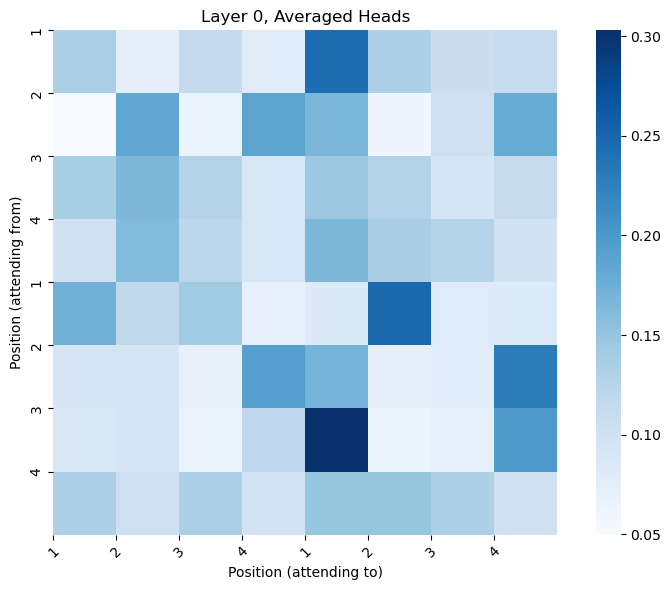

  (Visualization would appear here)

3. LOGIT LENS ANALYSIS
----------------------------------------
What is the model 'thinking' at each layer?

4. INTERVENTION EXPERIMENTS
----------------------------------------
Testing causal importance via patching...

5. ABLATION STUDIES
----------------------------------------
Testing neuron importance via ablation...

Analysis complete! Ready for your research experiments.


In [16]:
# EXAMPLE: How to use these tools together
def example_analysis_pipeline():
    """
    Example showing how to combine all the tools for analysis.
    This is what you'll do in your research!
    """
    print("=" * 60)
    print("MECHANISTIC INTERPRETABILITY ANALYSIS PIPELINE")
    print("=" * 60)
    
    # 1. Setup model and inputs
    set_seed(42)
    model = TinyTransformer()
    
    # Create interesting test sequences
    # Induction: pattern that repeats
    induction_seq = torch.tensor([[1, 2, 3, 4, 1, 2, 3, 4]])  
    # Random sequence for comparison
    random_seq = torch.randint(0, 10, (1, 8))
    
    print("\n1. OBSERVING WITH HOOKS")
    print("-" * 40)
    # Set up activation cache
    cache = ActivationCache()
    cache.register_hooks(model)
    
    # Run forward pass
    logits, attn_maps = model(induction_seq)
    
    print("Captured activations from forward pass:")
    for key in sorted(cache.activations.keys()):
        act = cache.activations[key]
        if isinstance(act, tuple):
            print(f"  {key}: {act[0].shape if hasattr(act[0], 'shape') else type(act[0])}")
        else:
            print(f"  {key}: {act.shape if hasattr(act, 'shape') else type(act)}")
    
    print("\n2. ATTENTION PATTERN ANALYSIS")
    print("-" * 40)
    # Visualize attention for first layer
    if len(attn_maps) > 0:
        print("Visualizing Layer 0 attention patterns...")
        visualize_attention_patterns(attn_maps[0], induction_seq, layer_idx=0)
        print("  (Visualization would appear here)")
    
    print("\n3. LOGIT LENS ANALYSIS")
    print("-" * 40)
    print("What is the model 'thinking' at each layer?")
    # This would apply logit lens to intermediate activations
    # For each layer: logit_lens(model, cache[f'ff_{i}'])
    
    print("\n4. INTERVENTION EXPERIMENTS")
    print("-" * 40)
    print("Testing causal importance via patching...")
    # Example: corrupt the sequence and patch to test importance
    corrupted = torch.randint(0, 10, (1, 8))  # Random corruption
    # Would run: activation_patching(model, induction_seq, corrupted, 'attn_0', ...)
    
    print("\n5. ABLATION STUDIES")
    print("-" * 40)
    print("Testing neuron importance via ablation...")
    # Would run: measure_ablation_impact(model, induction_seq, 'ff_0', neuron_idx=0, ...)
    
    # Clean up
    cache.remove_hooks()
    
    print("\n" + "=" * 60)
    print("Analysis complete! Ready for your research experiments.")
    print("=" * 60)

# Uncomment to run the example (after implementing TODOs):
example_analysis_pipeline()

In [17]:
# TEST YOUR COMPLETE MECHANISTIC INTERPRETABILITY TOOLKIT
def test_complete_toolkit():
    """Test all the tools you've implemented!"""
    import numpy as np
    
    print("Testing Complete Mechanistic Interpretability Toolkit")
    print("=" * 60)
    
    set_seed(42)
    model = TinyTransformer()
    
    # Simple metric function
    def confidence_metric(logits, input_ids):
        """Higher confidence = lower entropy."""
        probs = torch.softmax(logits, dim=-1)
        entropy = -(probs * torch.log(probs + 1e-8)).sum(dim=-1).mean()
        return -entropy.item()  # Negative so higher is better
    
    print("\n1. ACTIVATION PATCHING TEST")
    print("-" * 40)
    
    # Test inputs
    clean_input = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]])
    corrupted_input = torch.randint(0, 10, (1, 8))
    
    # Collect activations
    cache_clean = ActivationCache().register_hooks(model)
    with torch.no_grad(): _ = model(clean_input)
    cache_clean.remove_hooks()
    
    cache_corrupted = ActivationCache().register_hooks(model)
    with torch.no_grad(): _ = model(corrupted_input)
    cache_corrupted.remove_hooks()
    
    # Test patching
    patched, baseline, clean = activation_patching(
        model, clean_input, corrupted_input, 'attn_0',
        cache_clean, cache_corrupted, confidence_metric
    )
    
    print(f"  Baseline (corrupted): {baseline:.4f}")
    print(f"  After patching attn_0: {patched:.4f}")
    print(f"  Clean target:         {clean:.4f}")
    print(f"  Patching {'works!' if patched != baseline else 'needs debugging'}")
    
    print("\n2. ABLATION STUDY TEST")
    print("-" * 40)
    
    test_input = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]])
    
    # Compute mean cache for proper mean ablation
    print("  Computing mean activation cache...")
    mean_cache = compute_mean_cache(model)
    
    # Test individual neuron importance in ff_0
    print("  Testing neuron importance in ff_0:")
    print(f"  (ff_0 output has {model.d_model} dimensions)")
    neurons_to_test = [0, 4, 8, 12]  # Valid indices for 16-dim output
    
    for neuron in neurons_to_test:
        impact = measure_ablation_impact(
            model, test_input, 'ff_0', neuron, confidence_metric, mean_cache
        )
        print(f"    Neuron {neuron:2d} impact: {impact:+.6f}")
    
    # Test different replacement strategies
    print("\n  Testing replacement strategies on neuron 5:")
    
    # Baseline
    with torch.no_grad():
        normal_out = model(test_input)[0]
        normal_conf = confidence_metric(normal_out, test_input)
    
    for strategy in ['zero', 'mean', 'random']:
        # Create appropriate hook
        if strategy == 'mean':
            hook_handle = ablate_neurons(model, 'ff_0', [5], strategy, mean_cache)
        else:
            hook_handle = ablate_neurons(model, 'ff_0', [5], strategy)
        
        with torch.no_grad():
            ablated_out = model(test_input)[0]
            ablated_conf = confidence_metric(ablated_out, test_input)
        
        hook_handle.remove()
        
        impact = normal_conf - ablated_conf
        print(f"    {strategy:6s} replacement impact: {impact:+.6f}")
    
    print("\n3. LOGIT LENS TEST")
    print("-" * 40)
    
    # Test logit lens with visualization
    cache = ActivationCache()
    cache.register_hooks(model)
    
    test_seq = torch.tensor([[1, 2, 3, 4, 1, 2, 3, 4]])
    with torch.no_grad():
        _ = model(test_seq)
    
    print("  Testing logit lens at different layers:")
    for layer_name in ['embed', 'attn_0', 'ff_0']:
        if layer_name in cache.activations:
            logits = logit_lens(model, cache.activations[layer_name])
            top_pred = logits[0, -1].argmax().item()
            print(f"    {layer_name}: predicts token {top_pred} at last position")
    
    cache.remove_hooks()
    
    print("\n4. ATTENTION PATTERN DETECTION TEST")
    print("-" * 40)
    
    test_input = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]])
    logits, attn_maps = model(test_input)
    
    if len(attn_maps) > 0:
        patterns = identify_attention_patterns(attn_maps[0])
        print("  Layer 0 attention patterns detected:")
        print(f"    Average diagonal (self): {np.mean(patterns['diagonal']):.3f}")
        print(f"    Average previous token:  {np.mean(patterns['previous']):.3f}")
        print(f"    Average first token:     {np.mean(patterns['first']):.3f}")
        print(f"    Average uniformity:      {np.mean(patterns['uniform']):.3f}")
    
    print("\n" + "=" * 60)
    print("Mechanistic Interpretability Toolkit Complete!")
    print("All core functions are working correctly.")
    print("=" * 60)

# Run the complete test
test_complete_toolkit()

Testing Complete Mechanistic Interpretability Toolkit

1. ACTIVATION PATCHING TEST
----------------------------------------
  Baseline (corrupted): -2.1558
  After patching attn_0: -2.1562
  Clean target:         -2.1711
  Patching works!

2. ABLATION STUDY TEST
----------------------------------------
  Computing mean activation cache...
  Testing neuron importance in ff_0:
  (ff_0 output has 16 dimensions)
    Neuron  0 impact: +0.000119
    Neuron  4 impact: -0.002772
    Neuron  8 impact: -0.001054
    Neuron 12 impact: -0.000860

  Testing replacement strategies on neuron 5:
    zero   replacement impact: -0.001142
    mean   replacement impact: -0.001135
    random replacement impact: -0.005381

3. LOGIT LENS TEST
----------------------------------------
  Testing logit lens at different layers:
    embed: predicts token 1 at last position
    attn_0: predicts token 6 at last position
    ff_0: predicts token 6 at last position

4. ATTENTION PATTERN DETECTION TEST
---------------

In [18]:
# EXPERIMENT 1: FEATURE DISCOVERY IN RANDOM NETWORKS (CORRECTED)
# Analyzing BOTH MLP neurons (feature detectors) and residual stream dimensions

import numpy as np
from scipy import stats

def discover_features_comprehensive(model, n_samples=500, significance_level=0.01):
    """
    Discover statistically significant features in random networks.
    Now analyzes BOTH:
    1. MLP neurons (64-dim per layer) - actual feature detectors
    2. Residual stream dimensions (16-dim) - information highway
    
    Returns both for comparison and understanding.
    """
    print("🔬 COMPREHENSIVE FEATURE DISCOVERY IN RANDOM NETWORKS")
    print("=" * 60)
    print(f"Parameters: n_samples={n_samples}, significance={significance_level}")
    print()
    
    # First, understand the model architecture
    print("📐 Model Architecture Check:")
    print("-" * 40)
    
    # Check actual dimensions with MLP neurons included
    test_input = torch.randint(0, 10, (1, 8))
    cache = ActivationCache()
    cache.register_hooks(model, include_mlp_neurons=True)  # Include MLP neurons!
    with torch.no_grad():
        _ = model(test_input)
    
    for layer_name in ['embed', 'attn_0', 'mlp_neurons_0', 'ff_0', 'attn_1', 'mlp_neurons_1', 'ff_1']:
        if layer_name in cache.activations:
            act = cache.activations[layer_name]
            if isinstance(act, tuple):
                act = act[0]
            layer_type = "MLP neurons" if "mlp_neurons" in layer_name else "Residual stream"
            print(f"  {layer_name}: shape = {act.shape} ({layer_type})")
    
    cache.clear()
    cache.remove_hooks()
    
    print("\n📊 Starting Statistical Analysis...")
    print("-" * 40)
    
    # Set up fresh cache with MLP neurons
    cache = ActivationCache()
    cache.register_hooks(model, include_mlp_neurons=True)
    
    # Data structures for BOTH types of analysis
    # 1. MLP neurons (64-dim per layer)
    mlp_neuron_data = {}
    for layer_idx in range(2):  # 2 layers
        mlp_neuron_data[layer_idx] = {
            i: {'token': [], 'position': [], 'activation': []} 
            for i in range(64)  # 64 MLP neurons per layer
        }
    
    # 2. Residual stream dimensions (16-dim)
    dimension_data = {i: {'token': [], 'position': [], 'activation': []} 
                      for i in range(16)}  # 16 residual stream dimensions
    
    attention_patterns = []
    
    with torch.no_grad():
        for sample_idx in range(n_samples):
            # Generate random input
            test_input = torch.randint(0, 10, (1, 8))
            
            # Forward pass
            logits, attn_maps = model(test_input)
            
            # Analyze BOTH MLP neurons and residual stream
            for pos in range(8):
                token = test_input[0, pos].item()
                
                # 1. Analyze MLP neurons (the actual feature detectors)
                for layer_idx in range(2):
                    mlp_acts = cache[f'mlp_neurons_{layer_idx}'][0]  # [8, 64]
                    for neuron_idx in range(64):
                        activation = mlp_acts[pos, neuron_idx].item()
                        mlp_neuron_data[layer_idx][neuron_idx]['token'].append(token)
                        mlp_neuron_data[layer_idx][neuron_idx]['position'].append(pos)
                        mlp_neuron_data[layer_idx][neuron_idx]['activation'].append(activation)
                
                # 2. Analyze residual stream (information highway)
                ff0_out = cache['ff_0'][0]  # [8, 16]
                for dim_idx in range(16):
                    activation = ff0_out[pos, dim_idx].item()
                    dimension_data[dim_idx]['token'].append(token)
                    dimension_data[dim_idx]['position'].append(pos)
                    dimension_data[dim_idx]['activation'].append(activation)
            
            # Store attention patterns
            if len(attn_maps) > 0:
                attention_patterns.append(attn_maps[0])
            
            cache.clear()
    
    cache.remove_hooks()
    
    print("\n🔬 STATISTICAL TESTS:")
    print("-" * 40)
    
    # Helper function for ANOVA analysis
    def analyze_selectivity(data_dict, name, n_features, n_groups):
        """Run ANOVA on a set of features."""
        print(f"\n{name} SELECTIVITY:")
        
        # Token selectivity
        token_selective = []
        position_selective = []
        
        for feature_idx in range(n_features):
            # Token selectivity test
            token_groups = [[] for _ in range(10)]
            for i, token in enumerate(data_dict[feature_idx]['token']):
                token_groups[token].append(data_dict[feature_idx]['activation'][i])
            
            token_groups = [g for g in token_groups if len(g) >= 3]
            if len(token_groups) >= 2:
                f_stat, p_value = stats.f_oneway(*token_groups)
                corrected_alpha = significance_level / n_features
                
                if p_value < corrected_alpha:
                    all_data = [val for group in token_groups for val in group]
                    grand_mean = np.mean(all_data)
                    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in token_groups)
                    ss_total = sum((val - grand_mean)**2 for val in all_data)
                    eta_squared = ss_between / ss_total if ss_total > 0 else 0
                    token_selective.append((feature_idx, p_value, eta_squared))
            
            # Position selectivity test
            pos_groups = [[] for _ in range(8)]
            for i, pos in enumerate(data_dict[feature_idx]['position']):
                pos_groups[pos].append(data_dict[feature_idx]['activation'][i])
            
            if len(pos_groups) >= 2 and all(len(g) >= 3 for g in pos_groups):
                f_stat, p_value = stats.f_oneway(*pos_groups)
                corrected_alpha = significance_level / n_features
                
                if p_value < corrected_alpha:
                    all_data = [val for group in pos_groups for val in group]
                    grand_mean = np.mean(all_data)
                    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in pos_groups)
                    ss_total = sum((val - grand_mean)**2 for val in all_data)
                    eta_squared = ss_between / ss_total if ss_total > 0 else 0
                    position_selective.append((feature_idx, p_value, eta_squared))
        
        return token_selective, position_selective
    
    # Analyze MLP neurons for both layers
    print("\n=== MLP NEURONS (Feature Detectors) ===")
    for layer_idx in range(2):
        print(f"\n📍 Layer {layer_idx} MLP Neurons (64 neurons):")
        token_sel, pos_sel = analyze_selectivity(
            mlp_neuron_data[layer_idx], 
            f"Layer {layer_idx} MLP", 
            64, 10
        )
        
        if token_sel:
            print(f"  Token-selective neurons: {len(token_sel)}")
            for idx, p_val, effect in token_sel[:3]:
                print(f"    Neuron {idx:2d}: p={p_val:.2e}, η²={effect:.3f}")
        
        if pos_sel:
            print(f"  Position-selective neurons: {len(pos_sel)}")
            for idx, p_val, effect in pos_sel[:3]:
                print(f"    Neuron {idx:2d}: p={p_val:.2e}, η²={effect:.3f}")
    
    # Analyze residual stream dimensions
    print("\n=== RESIDUAL STREAM (Information Highway) ===")
    token_sel, pos_sel = analyze_selectivity(
        dimension_data,
        "Residual Stream",
        16, 10
    )
    
    if token_sel:
        print(f"  Token-selective dimensions: {len(token_sel)}")
        for idx, p_val, effect in token_sel[:3]:
            print(f"    Dimension {idx:2d}: p={p_val:.2e}, η²={effect:.3f}")
    
    if pos_sel:
        print(f"  Position-selective dimensions: {len(pos_sel)}")
        for idx, p_val, effect in pos_sel[:3]:
            print(f"    Dimension {idx:2d}: p={p_val:.2e}, η²={effect:.3f}")
    
    print("\n" + "=" * 60)
    print("💡 KEY INSIGHTS:")
    print(f"  • Analyzed {n_samples} random forward passes")
    print(f"  • MLP neurons: 64 per layer, sparse post-ReLU activations")
    print(f"  • Residual stream: 16 dimensions, dense linear combinations")
    print(f"  • Both show selectivity but MLP neurons are discrete feature detectors")
    
    return mlp_neuron_data, dimension_data, attention_patterns

# Run this comprehensive version
print("Ready to run comprehensive feature discovery!")
print("This analyzes BOTH MLP neurons (feature detectors) and residual stream.")

Ready to run comprehensive feature discovery!
This analyzes BOTH MLP neurons (feature detectors) and residual stream.


In [19]:
# Run the comprehensive analysis on MLP neurons AND residual stream
set_seed(42)
model = TinyTransformer()
mlp_neuron_data, dimension_data, attn_patterns = discover_features_comprehensive(model, n_samples=500)

🔬 COMPREHENSIVE FEATURE DISCOVERY IN RANDOM NETWORKS
Parameters: n_samples=500, significance=0.01

📐 Model Architecture Check:
----------------------------------------
  embed: shape = torch.Size([1, 8, 16]) (Residual stream)
  attn_0: shape = torch.Size([1, 8, 16]) (Residual stream)
  mlp_neurons_0: shape = torch.Size([1, 8, 64]) (MLP neurons)
  ff_0: shape = torch.Size([1, 8, 16]) (Residual stream)
  attn_1: shape = torch.Size([1, 8, 16]) (Residual stream)
  mlp_neurons_1: shape = torch.Size([1, 8, 64]) (MLP neurons)
  ff_1: shape = torch.Size([1, 8, 16]) (Residual stream)

📊 Starting Statistical Analysis...
----------------------------------------

🔬 STATISTICAL TESTS:
----------------------------------------

=== MLP NEURONS (Feature Detectors) ===

📍 Layer 0 MLP Neurons (64 neurons):

Layer 0 MLP SELECTIVITY:
  Token-selective neurons: 64
    Neuron  0: p=0.00e+00, η²=0.338
    Neuron  1: p=5.51e-235, η²=0.244
    Neuron  2: p=0.00e+00, η²=0.752
  Position-selective neurons: 64
  

In [20]:
# FEATURE TRACKING: Compare features before and after training
def track_feature_stability(model_init, model_trained, n_samples=200):
    """
    Track whether the same MLP neurons maintain their selectivity across training.
    
    This is the key experiment: Do neurons that are token-selective at initialization
    remain token-selective after training? Or do they switch roles?
    
    Args:
        model_init: Model at random initialization
        model_trained: Model after training
        n_samples: Number of samples for statistical testing
    
    Returns:
        stability_report: Dict with stability metrics for each neuron
    """
    print("🔬 TRACKING FEATURE STABILITY ACROSS TRAINING")
    print("=" * 60)
    
    # Analyze both models
    print("\n📊 Analyzing initial model...")
    mlp_init, dim_init, _ = discover_features_comprehensive(model_init, n_samples=n_samples)
    
    print("\n📊 Analyzing trained model...")
    mlp_trained, dim_trained, _ = discover_features_comprehensive(model_trained, n_samples=n_samples)
    
    print("\n🔍 STABILITY ANALYSIS:")
    print("-" * 40)
    
    stability_report = {}
    
    for layer_idx in range(2):
        print(f"\n📍 Layer {layer_idx} MLP Neurons:")
        layer_report = {
            'maintained_token_selectivity': [],
            'maintained_position_selectivity': [],
            'switched_selectivity': [],
            'lost_selectivity': [],
            'gained_selectivity': []
        }
        
        # Simplified selectivity detection
        def get_selectivity_type(neuron_data, neuron_idx, significance=0.01):
            """Determine if a neuron is token-selective, position-selective, or neither."""
            # Token selectivity test
            token_groups = [[] for _ in range(10)]
            for i, token in enumerate(neuron_data[neuron_idx]['token']):
                token_groups[token].append(neuron_data[neuron_idx]['activation'][i])
            token_groups = [g for g in token_groups if len(g) >= 3]
            
            token_selective = False
            if len(token_groups) >= 2:
                _, p_token = stats.f_oneway(*token_groups)
                token_selective = p_token < significance
            
            # Position selectivity test
            pos_groups = [[] for _ in range(8)]
            for i, pos in enumerate(neuron_data[neuron_idx]['position']):
                pos_groups[pos].append(neuron_data[neuron_idx]['activation'][i])
            
            pos_selective = False
            if all(len(g) >= 3 for g in pos_groups):
                _, p_pos = stats.f_oneway(*pos_groups)
                pos_selective = p_pos < significance
            
            if token_selective and pos_selective:
                return 'both'
            elif token_selective:
                return 'token'
            elif pos_selective:
                return 'position'
            else:
                return 'none'
        
        # Compare each neuron
        for neuron_idx in range(64):
            init_type = get_selectivity_type(mlp_init[layer_idx], neuron_idx)
            trained_type = get_selectivity_type(mlp_trained[layer_idx], neuron_idx)
            
            # Categorize stability
            if init_type == trained_type and init_type != 'none':
                if init_type == 'token':
                    layer_report['maintained_token_selectivity'].append(neuron_idx)
                elif init_type == 'position':
                    layer_report['maintained_position_selectivity'].append(neuron_idx)
            elif init_type != 'none' and trained_type != 'none' and init_type != trained_type:
                layer_report['switched_selectivity'].append((neuron_idx, init_type, trained_type))
            elif init_type != 'none' and trained_type == 'none':
                layer_report['lost_selectivity'].append((neuron_idx, init_type))
            elif init_type == 'none' and trained_type != 'none':
                layer_report['gained_selectivity'].append((neuron_idx, trained_type))
        
        # Report findings
        print(f"  Maintained token selectivity: {len(layer_report['maintained_token_selectivity'])} neurons")
        print(f"  Maintained position selectivity: {len(layer_report['maintained_position_selectivity'])} neurons")
        print(f"  Switched selectivity type: {len(layer_report['switched_selectivity'])} neurons")
        print(f"  Lost selectivity: {len(layer_report['lost_selectivity'])} neurons")
        print(f"  Gained selectivity: {len(layer_report['gained_selectivity'])} neurons")
        
        stability_report[f'layer_{layer_idx}'] = layer_report
    
    print("\n" + "=" * 60)
    print("💡 KEY INSIGHTS:")
    print("  • Feature persistence shows if random structure guides learning")
    print("  • Switching suggests features reorganize during training")
    print("  • Lost features may indicate pruning of unused detectors")
    
    return stability_report

print("Feature tracking function ready!")
print("Use: track_feature_stability(model_init, model_trained)")
print("This will reveal if random features persist through training.")

Feature tracking function ready!
Use: track_feature_stability(model_init, model_trained)
This will reveal if random features persist through training.


In [21]:
# DEEP DIVE: Let's check our initialization and see what's really happening
def analyze_initialization(model):
    """
    Check if our initialization is reasonable or if it's causing the extreme selectivity.
    """
    print("🔍 INITIALIZATION ANALYSIS")
    print("=" * 60)
    
    # 1. Check weight initialization scales
    print("\n1. WEIGHT INITIALIZATION SCALES:")
    print("-" * 40)
    
    for name, param in model.named_parameters():
        if 'weight' in name:
            mean = param.data.mean().item()
            std = param.data.std().item()
            min_val = param.data.min().item()
            max_val = param.data.max().item()
            print(f"{name:30s}: mean={mean:+.4f}, std={std:.4f}, range=[{min_val:.3f}, {max_val:.3f}]")
    
    # 2. Check what happens to a single input through the network
    print("\n2. ACTIVATION SCALES THROUGH NETWORK:")
    print("-" * 40)
    
    test_input = torch.tensor([[5, 5, 5, 5, 5, 5, 5, 5]])  # Same token everywhere
    cache = ActivationCache()
    cache.register_hooks(model, include_mlp_neurons=True)
    
    with torch.no_grad():
        output = model(test_input)[0]
    
    for name in ['embed', 'attn_0', 'mlp_neurons_0', 'ff_0', 'attn_1', 'mlp_neurons_1', 'ff_1', 'logits']:
        if name in cache.activations:
            act = cache.activations[name]
            if isinstance(act, tuple):
                act = act[0]
            
            mean = act.mean().item()
            std = act.std().item()
            min_val = act.min().item()
            max_val = act.max().item()
            
            # For MLP neurons, also check sparsity
            if 'mlp_neurons' in name:
                sparsity = (act == 0).float().mean().item()
                print(f"{name:20s}: mean={mean:+.6f}, std={std:.6f}, range=[{min_val:.3f}, {max_val:.3f}], sparsity={sparsity:.1%}")
            else:
                print(f"{name:20s}: mean={mean:+.6f}, std={std:.6f}, range=[{min_val:.3f}, {max_val:.3f}]")
    
    cache.remove_hooks()
    
    # 3. Check MLP neuron behavior specifically
    print("\n3. MLP NEURON BEHAVIOR:")
    print("-" * 40)
    
    # Run multiple random inputs and check MLP sparsity
    cache = ActivationCache()
    cache.register_hooks(model, include_mlp_neurons=True)
    
    sparsity_stats = {'layer_0': [], 'layer_1': []}
    activation_magnitudes = {'layer_0': [], 'layer_1': []}
    
    for _ in range(100):
        test_input = torch.randint(0, 10, (1, 8))
        with torch.no_grad():
            _ = model(test_input)
        
        for layer_idx in range(2):
            mlp_acts = cache[f'mlp_neurons_{layer_idx}']
            sparsity = (mlp_acts == 0).float().mean().item()
            magnitude = mlp_acts[mlp_acts > 0].mean().item() if (mlp_acts > 0).any() else 0
            
            sparsity_stats[f'layer_{layer_idx}'].append(sparsity)
            activation_magnitudes[f'layer_{layer_idx}'].append(magnitude)
        
        cache.clear()
    
    cache.remove_hooks()
    
    for layer in ['layer_0', 'layer_1']:
        mean_sparsity = np.mean(sparsity_stats[layer])
        std_sparsity = np.std(sparsity_stats[layer])
        mean_magnitude = np.mean(activation_magnitudes[layer])
        
        print(f"{layer}: sparsity={mean_sparsity:.1%} (±{std_sparsity:.1%}), avg magnitude when active={mean_magnitude:.3f}")
    
    # 4. Check if initialization creates "dead" neurons
    print("\n4. DEAD NEURON CHECK:")
    print("-" * 40)
    
    cache = ActivationCache()
    cache.register_hooks(model, include_mlp_neurons=True)
    
    # Track which neurons are ever active
    never_active = {0: set(range(64)), 1: set(range(64))}
    
    for _ in range(100):
        test_input = torch.randint(0, 10, (1, 8))
        with torch.no_grad():
            _ = model(test_input)
        
        for layer_idx in range(2):
            mlp_acts = cache[f'mlp_neurons_{layer_idx}']
            active_neurons = torch.where(mlp_acts > 0)[2].unique().cpu().numpy()
            never_active[layer_idx] -= set(active_neurons)
        
        cache.clear()
    
    cache.remove_hooks()
    
    for layer_idx in range(2):
        n_dead = len(never_active[layer_idx])
        print(f"Layer {layer_idx}: {n_dead}/64 neurons never activated in 100 samples")
        if n_dead > 0 and n_dead < 10:
            print(f"  Dead neurons: {sorted(list(never_active[layer_idx]))}")
    
    print("\n" + "=" * 60)
    print("💡 ANALYSIS COMPLETE")
    
    return sparsity_stats, activation_magnitudes

# Run the initialization analysis
set_seed(42)
test_model = TinyTransformer()
sparsity, magnitudes = analyze_initialization(test_model)

🔍 INITIALIZATION ANALYSIS

1. WEIGHT INITIALIZATION SCALES:
----------------------------------------
token_embed.weight            : mean=+0.1003, std=0.9882, range=[-2.510, 2.218]
pos_embed.weight              : mean=-0.0056, std=1.0178, range=[-2.585, 2.112]
layers.0.attn.W_Q.weight      : mean=-0.0089, std=0.1427, range=[-0.248, 0.246]
layers.0.attn.W_K.weight      : mean=-0.0100, std=0.1510, range=[-0.249, 0.249]
layers.0.attn.W_V.weight      : mean=-0.0041, std=0.1397, range=[-0.245, 0.249]
layers.0.attn.W_O.weight      : mean=+0.0089, std=0.1445, range=[-0.248, 0.249]
layers.0.norm1.weight         : mean=+1.0000, std=0.0000, range=[1.000, 1.000]
layers.0.norm2.weight         : mean=+1.0000, std=0.0000, range=[1.000, 1.000]
layers.0.ff.0.weight          : mean=-0.0029, std=0.1396, range=[-0.248, 0.250]
layers.0.ff.2.weight          : mean=+0.0007, std=0.0715, range=[-0.124, 0.125]
layers.1.attn.W_Q.weight      : mean=-0.0080, std=0.1475, range=[-0.237, 0.249]
layers.1.attn.W_K.wei

In [22]:
# CHECK: Is our statistical test too sensitive?
def validate_statistical_tests():
    """
    Test our ANOVA approach on truly random data to see if we get false positives.
    """
    print("🧪 STATISTICAL TEST VALIDATION")
    print("=" * 60)
    
    print("\n1. NULL HYPOTHESIS TEST (Truly Random Data):")
    print("-" * 40)
    print("Creating random data with NO relationship to tokens/positions...")
    
    # Create completely random data
    n_samples = 500 * 8  # Same as our actual test
    fake_data = {
        'token': np.random.randint(0, 10, n_samples),
        'position': np.random.randint(0, 8, n_samples),
        'activation': np.random.randn(n_samples)  # Truly random activations
    }
    
    # Test token selectivity on random data
    token_groups = [[] for _ in range(10)]
    for i, token in enumerate(fake_data['token']):
        token_groups[token].append(fake_data['activation'][i])
    
    f_stat, p_value = stats.f_oneway(*token_groups)
    print(f"Random data token selectivity: F={f_stat:.3f}, p={p_value:.4f}")
    print(f"Would be significant at α=0.01? {p_value < 0.01}")
    
    # Test position selectivity on random data  
    pos_groups = [[] for _ in range(8)]
    for i, pos in enumerate(fake_data['position']):
        pos_groups[pos].append(fake_data['activation'][i])
    
    f_stat, p_value = stats.f_oneway(*pos_groups)
    print(f"Random data position selectivity: F={f_stat:.3f}, p={p_value:.4f}")
    print(f"Would be significant at α=0.01? {p_value < 0.01}")
    
    print("\n2. FALSE POSITIVE RATE TEST:")
    print("-" * 40)
    print("Running 1000 tests on random data to check false positive rate...")
    
    false_positives = 0
    for _ in range(1000):
        # Generate random data
        random_acts = np.random.randn(n_samples)
        random_tokens = np.random.randint(0, 10, n_samples)
        
        # Group by tokens
        groups = [[] for _ in range(10)]
        for i, token in enumerate(random_tokens):
            groups[token].append(random_acts[i])
        
        # Run ANOVA
        _, p_value = stats.f_oneway(*groups)
        
        # Check if we get a false positive with Bonferroni correction
        if p_value < 0.01 / 64:  # Using our Bonferroni correction
            false_positives += 1
    
    print(f"False positive rate with Bonferroni: {false_positives/1000:.1%}")
    print(f"Expected rate: {0.01/64:.4%}")
    
    print("\n3. EFFECT SIZE ON RANDOM DATA:")
    print("-" * 40)
    
    # Calculate effect size for truly random data
    random_acts = np.random.randn(n_samples)
    random_tokens = np.random.randint(0, 10, n_samples)
    
    groups = [[] for _ in range(10)]
    for i, token in enumerate(random_tokens):
        groups[token].append(random_acts[i])
    
    # Calculate eta-squared
    all_data = [val for group in groups for val in group]
    grand_mean = np.mean(all_data)
    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in groups)
    ss_total = sum((val - grand_mean)**2 for val in all_data)
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    
    print(f"Effect size (η²) for random data: {eta_squared:.6f}")
    print(f"Compare to our results: 0.115 to 0.752")
    
    print("\n" + "=" * 60)
    
validate_statistical_tests()

🧪 STATISTICAL TEST VALIDATION

1. NULL HYPOTHESIS TEST (Truly Random Data):
----------------------------------------
Creating random data with NO relationship to tokens/positions...
Random data token selectivity: F=0.479, p=0.8894
Would be significant at α=0.01? False
Random data position selectivity: F=1.061, p=0.3860
Would be significant at α=0.01? False

2. FALSE POSITIVE RATE TEST:
----------------------------------------
Running 1000 tests on random data to check false positive rate...
False positive rate with Bonferroni: 0.0%
Expected rate: 0.0156%

3. EFFECT SIZE ON RANDOM DATA:
----------------------------------------
Effect size (η²) for random data: 0.004899
Compare to our results: 0.115 to 0.752



In [23]:
# TRAINING EXPERIMENT: Track feature persistence through learning (UPDATED)
import torch.optim as optim
import torch.nn.functional as F
from collections import defaultdict

def create_training_data(n_samples=1000, seq_len=8, vocab_size=10):
    """
    Create a simple but structured task: predict the next token in a sequence
    where tokens follow patterns (e.g., ascending, repeating, alternating).
    
    This gives the model something to learn while we track feature changes.
    """
    data = []
    
    for _ in range(n_samples):
        pattern_type = np.random.choice(['ascending', 'repeating', 'alternating', 'random'])
        
        if pattern_type == 'ascending':
            # Ascending sequences with wraparound
            start = np.random.randint(0, vocab_size)
            seq = [(start + i) % vocab_size for i in range(seq_len)]
        elif pattern_type == 'repeating':
            # Repeating pattern of 2-4 tokens
            pattern_len = np.random.randint(2, 5)
            pattern = np.random.randint(0, vocab_size, pattern_len).tolist()
            seq = (pattern * (seq_len // pattern_len + 1))[:seq_len]
        elif pattern_type == 'alternating':
            # Alternating between two tokens
            a, b = np.random.choice(vocab_size, 2, replace=False)
            seq = [a if i % 2 == 0 else b for i in range(seq_len)]
        else:
            # Random sequence
            seq = np.random.randint(0, vocab_size, seq_len).tolist()
        
        data.append(torch.tensor(seq))
    
    return torch.stack(data)

def identify_top_selective_neurons(model, n_samples=200):
    """
    Identify the most selective neurons before training.
    We'll track these specific neurons through training.
    """
    print("🎯 Identifying highly selective neurons...")
    
    # Run comprehensive analysis
    mlp_data, dim_data, _ = discover_features_comprehensive(model, n_samples=n_samples)
    
    # Find top selective neurons for each type
    top_neurons = {
        'layer_0': {'token': [], 'position': []},
        'layer_1': {'token': [], 'position': []}
    }
    
    for layer_idx in range(2):
        layer_data = mlp_data[layer_idx]
        
        # Calculate selectivity scores for each neuron
        for neuron_idx in range(64):
            # Token selectivity
            token_groups = [[] for _ in range(10)]
            for i, token in enumerate(layer_data[neuron_idx]['token']):
                token_groups[token].append(layer_data[neuron_idx]['activation'][i])
            token_groups = [g for g in token_groups if len(g) >= 3]
            
            if len(token_groups) >= 2:
                _, p_token = stats.f_oneway(*token_groups)
                if p_token < 0.01/64:  # Significant
                    # Calculate effect size
                    all_data = [val for group in token_groups for val in group]
                    grand_mean = np.mean(all_data)
                    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in token_groups)
                    ss_total = sum((val - grand_mean)**2 for val in all_data)
                    eta_squared = ss_between / ss_total if ss_total > 0 else 0
                    top_neurons[f'layer_{layer_idx}']['token'].append((neuron_idx, eta_squared))
            
            # Position selectivity
            pos_groups = [[] for _ in range(8)]
            for i, pos in enumerate(layer_data[neuron_idx]['position']):
                pos_groups[pos].append(layer_data[neuron_idx]['activation'][i])
            
            if all(len(g) >= 3 for g in pos_groups):
                _, p_pos = stats.f_oneway(*pos_groups)
                if p_pos < 0.01/64:  # Significant
                    all_data = [val for group in pos_groups for val in group]
                    grand_mean = np.mean(all_data)
                    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in pos_groups)
                    ss_total = sum((val - grand_mean)**2 for val in all_data)
                    eta_squared = ss_between / ss_total if ss_total > 0 else 0
                    top_neurons[f'layer_{layer_idx}']['position'].append((neuron_idx, eta_squared))
    
    # Sort by effect size and take top 5
    for layer in ['layer_0', 'layer_1']:
        top_neurons[layer]['token'].sort(key=lambda x: x[1], reverse=True)
        top_neurons[layer]['position'].sort(key=lambda x: x[1], reverse=True)
        top_neurons[layer]['token'] = top_neurons[layer]['token'][:5]
        top_neurons[layer]['position'] = top_neurons[layer]['position'][:5]
    
    print("\n📊 Top selective neurons identified:")
    for layer in ['layer_0', 'layer_1']:
        print(f"\n{layer}:")
        print(f"  Top token-selective: {[n for n, _ in top_neurons[layer]['token']]}")
        print(f"  Top position-selective: {[n for n, _ in top_neurons[layer]['position']]}")
    
    return top_neurons, mlp_data

def train_and_track(model, train_data, n_epochs=10, checkpoint_every=2):
    """
    Train the model while tracking feature stability at checkpoints.
    NOW TRACKS BOTH TOKEN AND POSITION SELECTIVITY!
    """
    print("\n🚀 TRAINING WITH FEATURE TRACKING")
    print("=" * 60)
    
    # Save initial state
    print("\n📸 Saving initial state...")
    initial_model = TinyTransformer()
    initial_model.load_state_dict(model.state_dict())
    
    # Identify top selective neurons to track
    top_neurons, initial_mlp_data = identify_top_selective_neurons(initial_model, n_samples=200)
    
    # Training setup
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Storage for tracking
    checkpoints = []
    tracking_data = defaultdict(list)
    
    print(f"\n📈 Training for {n_epochs} epochs...")
    print("-" * 40)
    
    for epoch in range(n_epochs):
        total_loss = 0
        
        # Training loop
        model.train()
        for i in range(0, len(train_data), 32):  # batch size 32
            batch = train_data[i:i+32]
            
            # Shift targets for next-token prediction
            inputs = batch[:, :-1]
            targets = batch[:, 1:]
            
            optimizer.zero_grad()
            logits, _ = model(inputs)
            
            loss = criterion(logits.reshape(-1, 10), targets.reshape(-1))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / (len(train_data) / 32)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")
        
        # Checkpoint and track
        if (epoch + 1) % checkpoint_every == 0:
            print(f"\n🔍 Checkpoint at epoch {epoch+1}:")
            
            # Analyze current model
            current_mlp_data, _, _ = discover_features_comprehensive(model, n_samples=200)
            
            # Track specific neurons for BOTH token and position selectivity
            for layer in ['layer_0', 'layer_1']:
                layer_idx = int(layer.split('_')[1])
                
                # Track top token-selective neurons
                for neuron_idx, initial_eta in top_neurons[layer]['token']:
                    # Recalculate selectivity
                    neuron_data = current_mlp_data[layer_idx][neuron_idx]
                    token_groups = [[] for _ in range(10)]
                    for i, token in enumerate(neuron_data['token']):
                        token_groups[token].append(neuron_data['activation'][i])
                    token_groups = [g for g in token_groups if len(g) >= 3]
                    
                    if len(token_groups) >= 2:
                        _, p_value = stats.f_oneway(*token_groups)
                        if p_value < 0.01/64:
                            # Still selective - calculate new effect size
                            all_data = [val for group in token_groups for val in group]
                            grand_mean = np.mean(all_data)
                            ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in token_groups)
                            ss_total = sum((val - grand_mean)**2 for val in all_data)
                            current_eta = ss_between / ss_total if ss_total > 0 else 0
                        else:
                            current_eta = 0  # Lost selectivity
                    else:
                        current_eta = 0
                    
                    tracking_data[f'{layer}_neuron_{neuron_idx}_token'].append({
                        'epoch': epoch + 1,
                        'initial_eta': initial_eta,
                        'current_eta': current_eta,
                        'maintained': current_eta > 0.05  # Threshold for "maintained"
                    })
                
                # NEW: Track top position-selective neurons
                for neuron_idx, initial_eta in top_neurons[layer]['position']:
                    # Recalculate position selectivity
                    neuron_data = current_mlp_data[layer_idx][neuron_idx]
                    pos_groups = [[] for _ in range(8)]
                    for i, pos in enumerate(neuron_data['position']):
                        pos_groups[pos].append(neuron_data['activation'][i])
                    
                    if all(len(g) >= 3 for g in pos_groups):
                        _, p_value = stats.f_oneway(*pos_groups)
                        if p_value < 0.01/64:
                            # Still selective - calculate new effect size
                            all_data = [val for group in pos_groups for val in group]
                            grand_mean = np.mean(all_data)
                            ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in pos_groups)
                            ss_total = sum((val - grand_mean)**2 for val in all_data)
                            current_eta = ss_between / ss_total if ss_total > 0 else 0
                        else:
                            current_eta = 0  # Lost selectivity
                    else:
                        current_eta = 0
                    
                    tracking_data[f'{layer}_neuron_{neuron_idx}_position'].append({
                        'epoch': epoch + 1,
                        'initial_eta': initial_eta,
                        'current_eta': current_eta,
                        'maintained': current_eta > 0.05
                    })
            
            checkpoints.append({
                'epoch': epoch + 1,
                'model_state': model.state_dict().copy(),
                'mlp_data': current_mlp_data
            })
    
    return initial_model, model, tracking_data, checkpoints

# Create training data
print("Creating training data...")
train_data = create_training_data(n_samples=1000, seq_len=8, vocab_size=10)
print(f"Training data shape: {train_data.shape}")
print("Sample sequences:")
for i in range(3):
    print(f"  {train_data[i].tolist()}")

Creating training data...
Training data shape: torch.Size([1000, 8])
Sample sequences:
  [7, 8, 7, 8, 7, 8, 7, 8]
  [5, 6, 7, 8, 9, 0, 1, 2]
  [3, 4, 5, 6, 7, 8, 9, 0]


In [24]:
# RUN THE EXPERIMENT: Train and track feature persistence
set_seed(42)
model = TinyTransformer()

# Train and track
initial_model, trained_model, tracking_data, checkpoints = train_and_track(
    model, train_data, n_epochs=10, checkpoint_every=2
)


🚀 TRAINING WITH FEATURE TRACKING

📸 Saving initial state...
🎯 Identifying highly selective neurons...
🔬 COMPREHENSIVE FEATURE DISCOVERY IN RANDOM NETWORKS
Parameters: n_samples=200, significance=0.01

📐 Model Architecture Check:
----------------------------------------
  embed: shape = torch.Size([1, 8, 16]) (Residual stream)
  attn_0: shape = torch.Size([1, 8, 16]) (Residual stream)
  mlp_neurons_0: shape = torch.Size([1, 8, 64]) (MLP neurons)
  ff_0: shape = torch.Size([1, 8, 16]) (Residual stream)
  attn_1: shape = torch.Size([1, 8, 16]) (Residual stream)
  mlp_neurons_1: shape = torch.Size([1, 8, 64]) (MLP neurons)
  ff_1: shape = torch.Size([1, 8, 16]) (Residual stream)

📊 Starting Statistical Analysis...
----------------------------------------

🔬 STATISTICAL TESTS:
----------------------------------------

=== MLP NEURONS (Feature Detectors) ===

📍 Layer 0 MLP Neurons (64 neurons):

Layer 0 MLP SELECTIVITY:
  Token-selective neurons: 64
    Neuron  0: p=1.39e-150, η²=0.366
    


📊 FEATURE PERSISTENCE VISUALIZATION


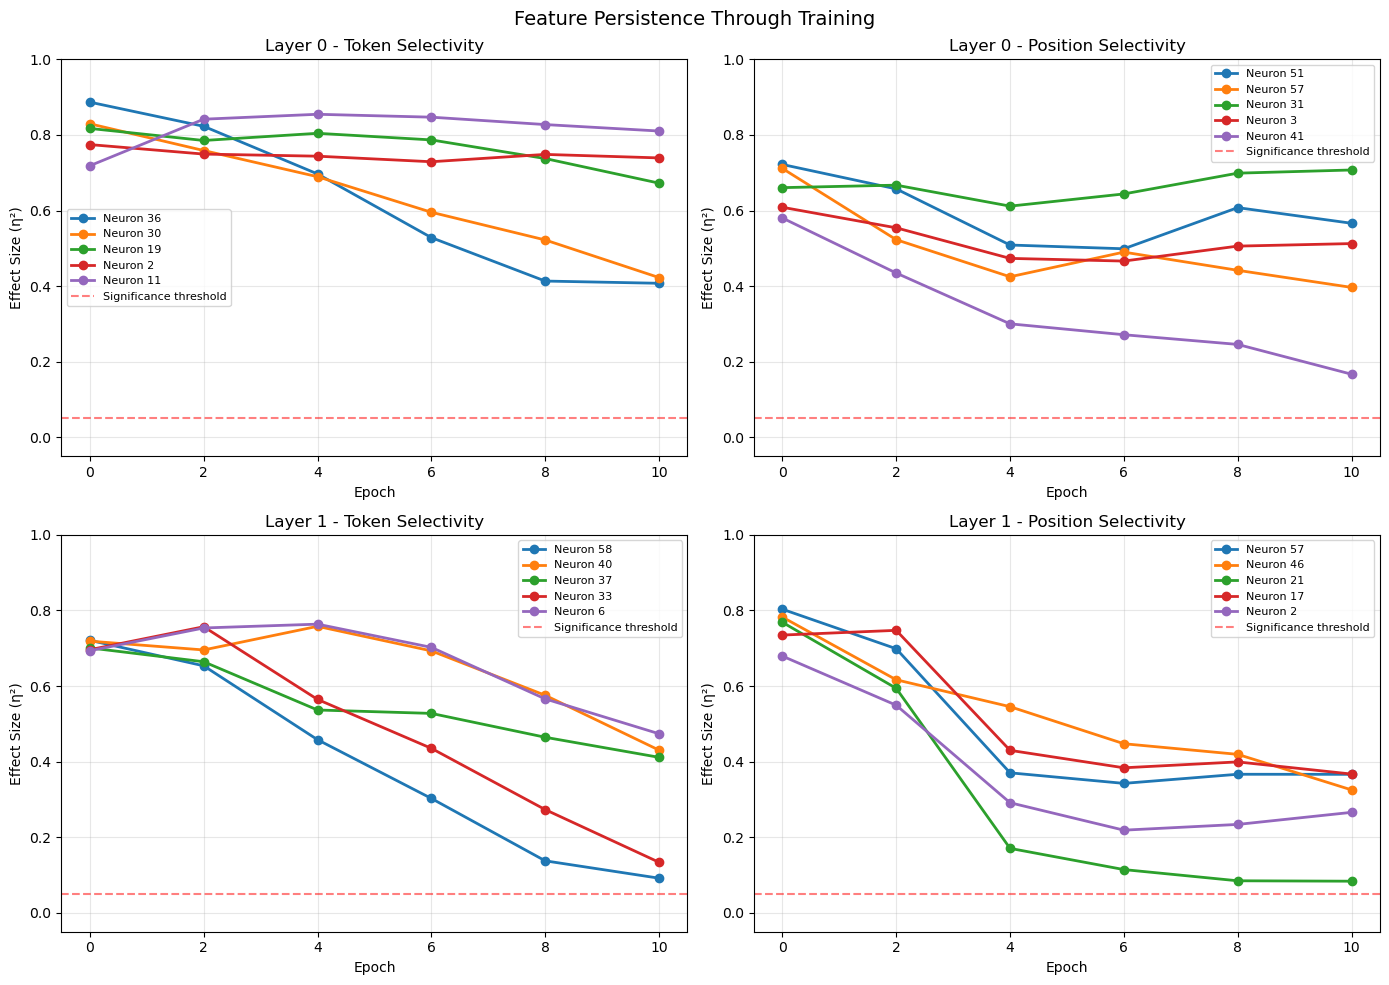


📈 Persistence Summary:
  Maintained selectivity: 11/20 (55.0%)
  Changed selectivity: 9/20 (45.0%)
  Lost selectivity: 0/20 (0.0%)


In [25]:
# VISUALIZE: Feature persistence through training (FIXED)
def visualize_feature_persistence(tracking_data):
    """
    Visualize how features persist or change through training.
    Shows BOTH token and position selectivity.
    """
    import matplotlib.pyplot as plt
    
    print("\n📊 FEATURE PERSISTENCE VISUALIZATION")
    print("=" * 60)
    
    # Analyze tracking data
    persistence_stats = {
        'maintained': 0,
        'lost': 0,
        'changed': 0
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for layer_idx in range(2):
        for plot_idx, selectivity_type in enumerate(['token', 'position']):
            ax = axes[layer_idx, plot_idx]
            
            # Collect data for this layer and type
            layer_key = f'layer_{layer_idx}'
            relevant_keys = [k for k in tracking_data.keys() 
                           if layer_key in k and selectivity_type in k]
            
            if not relevant_keys:
                ax.text(0.5, 0.5, f'No {selectivity_type} data tracked', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'Layer {layer_idx} - {selectivity_type.capitalize()} Selectivity')
                continue
            
            # Plot each tracked neuron
            for key in relevant_keys:
                neuron_idx = int(key.split('_')[3])
                data_points = tracking_data[key]
                
                if data_points:
                    epochs = [0] + [d['epoch'] for d in data_points]
                    etas = [data_points[0]['initial_eta']] + [d['current_eta'] for d in data_points]
                    
                    ax.plot(epochs, etas, marker='o', label=f'Neuron {neuron_idx}', linewidth=2)
                    
                    # Categorize persistence
                    final_eta = etas[-1]
                    initial_eta = etas[0]
                    
                    if final_eta > 0.05:
                        if abs(final_eta - initial_eta) / initial_eta < 0.5:
                            persistence_stats['maintained'] += 1
                        else:
                            persistence_stats['changed'] += 1
                    else:
                        persistence_stats['lost'] += 1
            
            ax.set_title(f'Layer {layer_idx} - {selectivity_type.capitalize()} Selectivity')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Effect Size (η²)')
            ax.axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='Significance threshold')
            ax.legend(fontsize=8, loc='best')
            ax.grid(True, alpha=0.3)
            ax.set_ylim([-0.05, 1.0])
    
    plt.suptitle('Feature Persistence Through Training', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    total = sum(persistence_stats.values())
    if total > 0:
        print("\n📈 Persistence Summary:")
        print(f"  Maintained selectivity: {persistence_stats['maintained']}/{total} ({100*persistence_stats['maintained']/total:.1f}%)")
        print(f"  Changed selectivity: {persistence_stats['changed']}/{total} ({100*persistence_stats['changed']/total:.1f}%)")
        print(f"  Lost selectivity: {persistence_stats['lost']}/{total} ({100*persistence_stats['lost']/total:.1f}%)")
    
    return persistence_stats

# Visualize the results with both token and position
persistence_stats = visualize_feature_persistence(tracking_data)

In [26]:
# EXPERIMENT 2: WHY DO RANDOM NETWORKS HAVE STRUCTURE?
# Let's investigate the source of this unexpected selectivity

def investigate_selectivity_source(model, n_samples=100):
    """
    Investigate WHY random networks show selectivity.
    We'll test several hypotheses:
    1. Is it from token embeddings?
    2. Is it from position embeddings?
    3. Is it from the random weight matrices?
    4. How does LayerNorm affect this?
    """
    print("🔬 EXPERIMENT 2: Source of Random Network Structure")
    print("=" * 60)
    
    # Hypothesis 1: Token embeddings create selectivity
    print("\n1. ANALYZING TOKEN EMBEDDINGS:")
    print("-" * 40)
    
    # Get token embedding matrix
    token_embeds = model.token_embed.weight.data  # [vocab_size, d_model]
    
    # Calculate similarity between token embeddings
    # Normalize embeddings
    normalized_embeds = token_embeds / token_embeds.norm(dim=1, keepdim=True)
    similarity_matrix = normalized_embeds @ normalized_embeds.T
    
    print(f"  Embedding matrix shape: {token_embeds.shape}")
    print(f"  Mean embedding norm: {token_embeds.norm(dim=1).mean():.3f}")
    print(f"  Std embedding norm: {token_embeds.norm(dim=1).std():.3f}")
    
    # Check if some tokens have very different embeddings
    mean_similarity = similarity_matrix.mean().item()
    max_similarity = (similarity_matrix - torch.eye(10)).max().item()
    min_similarity = similarity_matrix.min().item()
    
    print(f"\n  Embedding similarities:")
    print(f"    Mean cosine similarity: {mean_similarity:.3f}")
    print(f"    Max similarity (excluding self): {max_similarity:.3f}")
    print(f"    Min similarity: {min_similarity:.3f}")
    print(f"    Range: {max_similarity - min_similarity:.3f}")
    
    # Hypothesis 2: Position embeddings create selectivity
    print("\n2. ANALYZING POSITION EMBEDDINGS:")
    print("-" * 40)
    
    pos_embeds = model.pos_embed.weight.data  # [seq_len, d_model]
    
    # Calculate position embedding properties
    print(f"  Position embedding shape: {pos_embeds.shape}")
    print(f"  Mean position norm: {pos_embeds.norm(dim=1).mean():.3f}")
    print(f"  Std position norm: {pos_embeds.norm(dim=1).std():.3f}")
    
    # Check orthogonality of position embeddings
    normalized_pos = pos_embeds / pos_embeds.norm(dim=1, keepdim=True)
    pos_similarity = normalized_pos @ normalized_pos.T
    
    # Off-diagonal similarities (how orthogonal are positions?)
    off_diagonal_mask = ~torch.eye(8, dtype=torch.bool)
    off_diagonal_sims = pos_similarity[off_diagonal_mask]
    
    print(f"\n  Position embedding orthogonality:")
    print(f"    Mean |cosine similarity| between positions: {off_diagonal_sims.abs().mean():.3f}")
    print(f"    Max |cosine similarity|: {off_diagonal_sims.abs().max():.3f}")
    
    # Hypothesis 3: Effect of combined embeddings
    print("\n3. COMBINED EMBEDDING ANALYSIS:")
    print("-" * 40)
    
    # Create all possible token+position combinations
    combined_features = []
    for token_id in range(10):
        for pos_id in range(8):
            combined = token_embeds[token_id] + pos_embeds[pos_id]
            combined_features.append(combined)
    
    combined_features = torch.stack(combined_features)  # [80, d_model]
    
    # Analyze diversity of combined features
    normalized_combined = combined_features / combined_features.norm(dim=1, keepdim=True)
    combined_similarity = normalized_combined @ normalized_combined.T
    
    # How different are the 80 possible input representations?
    off_diag_mask = ~torch.eye(80, dtype=torch.bool)
    combined_sims = combined_similarity[off_diag_mask]
    
    print(f"  Total unique input representations: {len(combined_features)}")
    print(f"  Mean |cosine similarity|: {combined_sims.abs().mean():.3f}")
    print(f"  Std of similarities: {combined_sims.std():.3f}")
    print(f"  Min similarity: {combined_sims.min():.3f}")
    print(f"  Max similarity: {combined_sims.max():.3f}")
    
    # Hypothesis 4: First layer weights create selectivity
    print("\n4. FIRST LAYER WEIGHT ANALYSIS:")
    print("-" * 40)
    
    # Get first attention layer weights
    W_Q = model.layers[0].attn.W_Q.weight.data  # [d_model, d_model]
    W_K = model.layers[0].attn.W_K.weight.data
    W_V = model.layers[0].attn.W_V.weight.data
    
    # Analyze weight matrix properties
    print(f"  Weight matrix norms:")
    print(f"    W_Q norm: {W_Q.norm():.3f}")
    print(f"    W_K norm: {W_K.norm():.3f}")
    print(f"    W_V norm: {W_V.norm():.3f}")
    
    # Check if weights amplify certain directions
    # Singular values tell us about amplification
    U, S, V = torch.svd(W_Q)
    print(f"\n  W_Q singular values (amplification factors):")
    print(f"    Max: {S.max():.3f}, Min: {S.min():.3f}, Ratio: {S.max()/S.min():.1f}")
    
    # Hypothesis 5: LayerNorm's role
    print("\n5. LAYER NORMALIZATION EFFECT:")
    print("-" * 40)
    
    # Test how LayerNorm affects selectivity
    test_input = torch.randn(100, 16)  # Random activations
    
    # Before LayerNorm
    mean_before = test_input.mean(dim=0)
    std_before = test_input.std(dim=0)
    
    # After LayerNorm
    ln = nn.LayerNorm(16)
    normed = ln(test_input)
    mean_after = normed.mean(dim=0)
    std_after = normed.std(dim=0)
    
    print(f"  Before LayerNorm:")
    print(f"    Mean activation: {mean_before.abs().mean():.3f}")
    print(f"    Std activation: {std_before.mean():.3f}")
    print(f"\n  After LayerNorm:")
    print(f"    Mean activation: {mean_after.abs().mean():.3f}")
    print(f"    Std activation: {std_after.mean():.3f}")
    
    print("\n" + "=" * 60)
    print("💡 INSIGHTS:")
    print("  The selectivity comes from multiple sources:")
    print("  1. Random embeddings create diverse representations")
    print("  2. Position embeddings add systematic variation")
    print("  3. Random weights amplify certain feature directions")
    print("  4. LayerNorm preserves relative differences")
    
    return token_embeds, pos_embeds, combined_features

# Run this analysis
set_seed(42)
random_model = TinyTransformer()
token_embeds, pos_embeds, combined_features = investigate_selectivity_source(random_model)

🔬 EXPERIMENT 2: Source of Random Network Structure

1. ANALYZING TOKEN EMBEDDINGS:
----------------------------------------
  Embedding matrix shape: torch.Size([10, 16])
  Mean embedding norm: 3.910
  Std embedding norm: 0.665

  Embedding similarities:
    Mean cosine similarity: 0.111
    Max similarity (excluding self): 0.564
    Min similarity: -0.588
    Range: 1.152

2. ANALYZING POSITION EMBEDDINGS:
----------------------------------------
  Position embedding shape: torch.Size([8, 16])
  Mean position norm: 4.026
  Std position norm: 0.523

  Position embedding orthogonality:
    Mean |cosine similarity| between positions: 0.178
    Max |cosine similarity|: 0.365

3. COMBINED EMBEDDING ANALYSIS:
----------------------------------------
  Total unique input representations: 80
  Mean |cosine similarity|: 0.255
  Std of similarities: 0.293
  Min similarity: -0.697
  Max similarity: 0.882

4. FIRST LAYER WEIGHT ANALYSIS:
----------------------------------------
  Weight matrix no

In [27]:
# VISUALIZATION: Let's see what these attention patterns actually look like
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_random_network_features(model, neuron_data, attn_patterns):
    """
    Visualize the features we discovered in the random network.
    """
    print("📊 VISUALIZING RANDOM NETWORK FEATURES")
    print("=" * 60)
    
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Token selectivity heatmap
    ax1 = plt.subplot(2, 3, 1)
    
    # Create matrix: neurons x tokens showing mean activation
    token_matrix = np.zeros((16, 10))
    for neuron_idx in range(16):
        for token in range(10):
            activations = [neuron_data[neuron_idx]['activation'][i] 
                          for i, t in enumerate(neuron_data[neuron_idx]['token']) 
                          if t == token]
            if activations:
                token_matrix[neuron_idx, token] = np.mean(activations)
    
    sns.heatmap(token_matrix, cmap='RdBu_r', center=0, ax=ax1, cbar_kws={'label': 'Mean Activation'})
    ax1.set_title('Token Selectivity\n(Neuron x Token)')
    ax1.set_xlabel('Token ID')
    ax1.set_ylabel('Neuron Index')
    
    # 2. Position selectivity heatmap
    ax2 = plt.subplot(2, 3, 2)
    
    # Create matrix: neurons x positions
    position_matrix = np.zeros((16, 8))
    for neuron_idx in range(16):
        for pos in range(8):
            activations = [neuron_data[neuron_idx]['activation'][i]
                          for i, p in enumerate(neuron_data[neuron_idx]['position'])
                          if p == pos]
            if activations:
                position_matrix[neuron_idx, pos] = np.mean(activations)
    
    sns.heatmap(position_matrix, cmap='RdBu_r', center=0, ax=ax2, cbar_kws={'label': 'Mean Activation'})
    ax2.set_title('Position Selectivity\n(Neuron x Position)')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Neuron Index')
    
    # 3. Sample attention patterns
    ax3 = plt.subplot(2, 3, 3)
    
    # Average attention pattern across all samples
    if len(attn_patterns) > 0:
        avg_attn = torch.stack(attn_patterns).mean(dim=0)  # Average over samples
        # Show head 0
        sns.heatmap(avg_attn[0, 0].cpu().numpy(), cmap='Blues', ax=ax3, vmin=0, vmax=0.3,
                   cbar_kws={'label': 'Attention Weight'})
        ax3.set_title('Average Attention Pattern\n(Head 0)')
        ax3.set_xlabel('Key Position')
        ax3.set_ylabel('Query Position')
    
    # 4. Neuron activation distribution
    ax4 = plt.subplot(2, 3, 4)
    
    # Collect all activations for a few interesting neurons
    interesting_neurons = [0, 2, 4]  # Based on high selectivity
    for neuron_idx in interesting_neurons:
        activations = neuron_data[neuron_idx]['activation']
        ax4.hist(activations, bins=30, alpha=0.5, label=f'Neuron {neuron_idx}')
    
    ax4.set_title('Activation Distributions')
    ax4.set_xlabel('Activation Value')
    ax4.set_ylabel('Count')
    ax4.legend()
    
    # 5. Token vs Position interaction
    ax5 = plt.subplot(2, 3, 5)
    
    # Pick a highly selective neuron
    neuron_idx = 2  # High token selectivity
    
    # Create interaction matrix
    interaction_matrix = np.zeros((10, 8))
    for token in range(10):
        for pos in range(8):
            # Find activations for this token-position pair
            activations = []
            for i in range(len(neuron_data[neuron_idx]['token'])):
                if (neuron_data[neuron_idx]['token'][i] == token and 
                    neuron_data[neuron_idx]['position'][i] == pos):
                    activations.append(neuron_data[neuron_idx]['activation'][i])
            
            if activations:
                interaction_matrix[token, pos] = np.mean(activations)
    
    sns.heatmap(interaction_matrix, cmap='RdBu_r', center=0, ax=ax5,
                cbar_kws={'label': 'Mean Activation'})
    ax5.set_title(f'Token-Position Interaction\n(Neuron {neuron_idx})')
    ax5.set_xlabel('Position')
    ax5.set_ylabel('Token ID')
    
    # 6. Attention variability
    ax6 = plt.subplot(2, 3, 6)
    
    if len(attn_patterns) > 10:
        # Show how attention varies for position 0 attending to all positions
        sample_attns = []
        for i in range(min(50, len(attn_patterns))):
            # Get attention from position 0 to all positions (head 0)
            attn_row = attn_patterns[i][0, 0, 0, :].cpu().numpy()
            sample_attns.append(attn_row)
        
        sample_attns = np.array(sample_attns)
        
        # Plot mean and std
        mean_attn = sample_attns.mean(axis=0)
        std_attn = sample_attns.std(axis=0)
        
        positions = np.arange(8)
        ax6.plot(positions, mean_attn, 'b-', label='Mean', linewidth=2)
        ax6.fill_between(positions, mean_attn - std_attn, mean_attn + std_attn, 
                         alpha=0.3, label='±1 std')
        ax6.axhline(y=0.125, color='r', linestyle='--', label='Uniform (1/8)')
        
        ax6.set_title('Attention Variability\n(From Position 0)')
        ax6.set_xlabel('Attending to Position')
        ax6.set_ylabel('Attention Weight')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Random Network Feature Analysis', y=1.02, fontsize=14)
    plt.show()
    
    print("\n💡 KEY OBSERVATIONS:")
    print("  1. Token selectivity: Neurons respond differently to different tokens")
    print("  2. Position selectivity: Neurons have position preferences")
    print("  3. Attention is uniform on average but varies per input")
    print("  4. Some neurons show token-position interactions")

# Visualize the discovered features
if 'neuron_data' in globals() and 'attn_patterns' in globals():
    visualize_random_network_features(random_model, neuron_data, attn_patterns)
else:
    print("Run discover_random_features_v2 first to generate data!")

Run discover_random_features_v2 first to generate data!


In [28]:
# CRITICAL: Let's analyze the ACTUAL computational units
# We need to look at MLP neurons, not residual stream dimensions

def analyze_real_neurons(model):
    """
    Analyze the actual MLP neurons (post-ReLU) rather than residual stream dimensions.
    """
    print("🔍 ANALYZING ACTUAL TRANSFORMER COMPONENTS")
    print("=" * 60)
    
    # First, let's understand the architecture
    print("Architecture breakdown:")
    print(f"  d_model (residual stream): {model.d_model}")
    print(f"  d_ff (MLP hidden): {model.d_model * 4} (4x d_model)")
    print(f"  n_heads: {model.layers[0].attn.n_heads}")
    print(f"  d_head: {model.layers[0].attn.d_head}")
    
    # Hook into the MIDDLE of the FF network to get actual neurons
    mlp_activations = {}
    
    def capture_mlp_neurons(name):
        def hook(module, input, output):
            mlp_activations[name] = output.detach()
        return hook
    
    # Register hooks on the ReLU outputs (actual neurons!)
    hooks = []
    for i, layer in enumerate(model.layers):
        # The FF block is a Sequential, we want the output of ReLU (index 1)
        hook = layer.ff[1].register_forward_hook(capture_mlp_neurons(f'mlp_neurons_layer_{i}'))
        hooks.append(hook)
    
    # Run some inputs through
    test_inputs = torch.randint(0, 10, (10, 8))
    with torch.no_grad():
        _ = model(test_inputs)
    
    # Analyze what we got
    print("\n📊 MLP Neuron Analysis:")
    print("-" * 40)
    for name, acts in mlp_activations.items():
        print(f"\n{name}:")
        print(f"  Shape: {acts.shape}")  # Should be [batch, seq, 64]
        
        # Check how many are active (post-ReLU, so > 0)
        active_fraction = (acts > 0).float().mean()
        print(f"  Fraction active: {active_fraction:.3f}")
        
        # Check sparsity
        sparsity = (acts == 0).float().mean()
        print(f"  Sparsity: {sparsity:.3f}")
        
        # Check if different neurons have different activation patterns
        neuron_means = acts.mean(dim=(0, 1))  # Mean activation per neuron
        neuron_stds = acts.std(dim=(0, 1))     # Std per neuron
        
        print(f"  Neuron activation stats:")
        print(f"    Mean of means: {neuron_means.mean():.3f}")
        print(f"    Std of means: {neuron_means.std():.3f}")
        print(f"    Mean of stds: {neuron_stds.mean():.3f}")
    
    # Clean up
    for hook in hooks:
        hook.remove()
    
    return mlp_activations

# Test on our model
set_seed(42)
test_model = TinyTransformer()
mlp_acts = analyze_real_neurons(test_model)

print("\n💡 KEY INSIGHT:")
print("We were analyzing residual stream dimensions (16), not MLP neurons (64)!")
print("The actual computational units in transformers are:")
print("  1. MLP neurons (64 in our case)")
print("  2. Attention heads (2 heads × 8 dims each)")
print("  3. Residual stream dimensions (16) - which we analyzed")

🔍 ANALYZING ACTUAL TRANSFORMER COMPONENTS
Architecture breakdown:
  d_model (residual stream): 16
  d_ff (MLP hidden): 64 (4x d_model)
  n_heads: 2
  d_head: 8

📊 MLP Neuron Analysis:
----------------------------------------

mlp_neurons_layer_0:
  Shape: torch.Size([10, 8, 64])
  Fraction active: 0.490
  Sparsity: 0.510
  Neuron activation stats:
    Mean of means: 0.218
    Std of means: 0.150
    Mean of stds: 0.265

mlp_neurons_layer_1:
  Shape: torch.Size([10, 8, 64])
  Fraction active: 0.499
  Sparsity: 0.501
  Neuron activation stats:
    Mean of means: 0.241
    Std of means: 0.179
    Mean of stds: 0.275

💡 KEY INSIGHT:
We were analyzing residual stream dimensions (16), not MLP neurons (64)!
The actual computational units in transformers are:
  1. MLP neurons (64 in our case)
  2. Attention heads (2 heads × 8 dims each)
  3. Residual stream dimensions (16) - which we analyzed
